In [ ]:
%matplotlib notebook


39063
Edges with most_important_references=1: 852
21002
Number of edges in G_important: 852
Number of nodes in G_important: 1275
Removed 0 isolated nodes from G_important.
Using largest connected component with 113 nodes.
Number of edges in G_important: 117
Number of nodes in G_important: 113
Node positions:
58d82fc8d649053542fd5be4: [-0.58100473  0.4468164 ]
5db9298547c8f766461f8b65: [0.3794456  0.68385093]
5aed14e217c44a4438159759: [-0.70780701 -0.61942235]
5e982cc591e0119e8a952209: [ 0.74298674 -0.57984089]
5e09aa66df1a9c0c416bebf6: [0.49981388 0.05651741]
5ede0553e06a4c1b26a83f63: [0.01527611 0.54616442]
5e5e193793d709897ce5cdee: [-0.18342205  0.9518545 ]
5b67b45517c44aac1c860876: [-0.65914897  0.65322161]
5a9cb66717c44a376ffb8667: [0.6356589  0.77979449]
5dce788a3a55ac9580a162f8: [-0.16167966 -0.37144237]
5fdc8e9d91e01104c91811a8: [ 0.60183381 -0.10735572]
5f03f3b611dc830562232042: [-0.19678515 -0.27706737]
5c8d30274895d9cbc643dc9e: [-0.71208642  0.66183453]
5ce2d032ced107d4c63526

<Figure size 1500x1000 with 0 Axes>

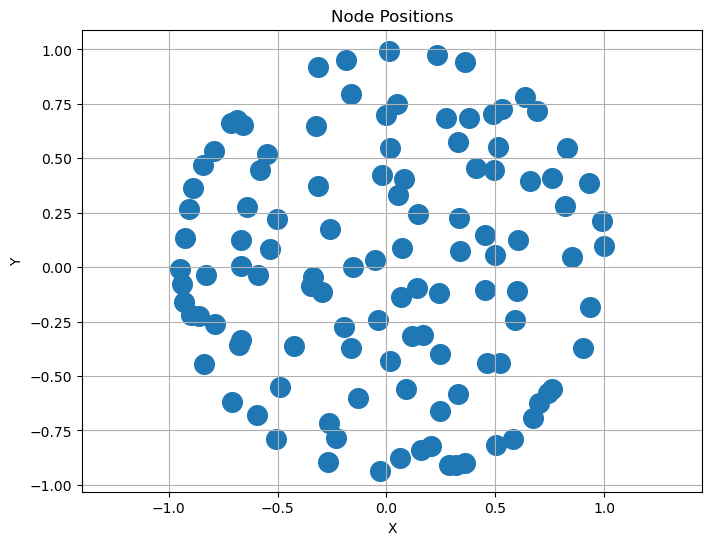

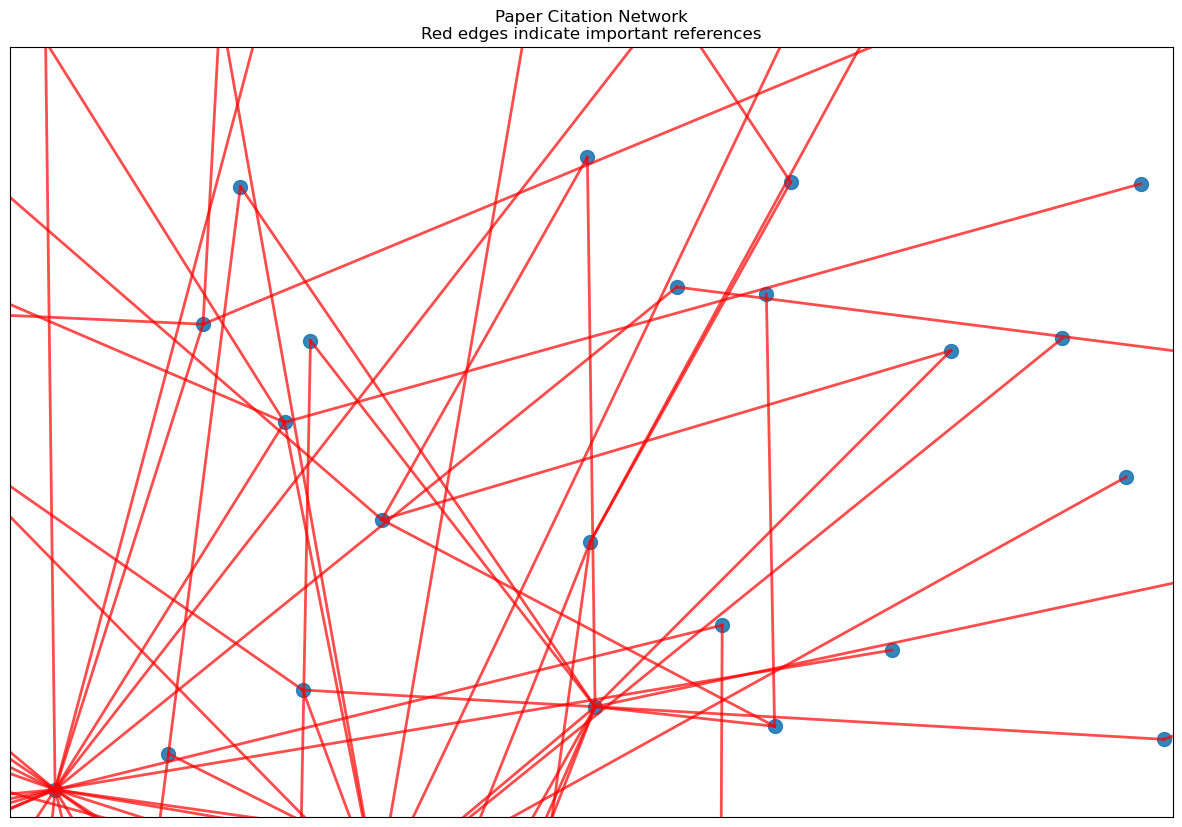

In [52]:
import networkx as nx
import numpy as np
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Registers the 3D projection

def load_embeddings(base_path):
    title_emb = pd.read_csv(f"{base_path}/title_embeddings.csv", index_col=0).transpose()
    abstract_emb = pd.read_csv(f"{base_path}/abstract_embeddings.csv", index_col=0).transpose()
    return title_emb, abstract_emb

def load_paper_sources(base_path, rules=True):
    with open(f"{base_path}/paper_source_trace_valid_wo_ans.json", "r") as f:
        paper_source = json.load(f)
    with open(f"{base_path}/paper_source_trace_train_ans.json", "r") as f:
        paper_source_train = json.load(f)
    if rules:
        with open(f"{base_path}/paper_source_gen_by_rule.json", "r") as f:
            paper_source_rule = json.load(f)
            rule_papers = [{"_id": pid, "references": list(refs.values())} 
                      for pid, refs in paper_source_rule.items()]
        return paper_source + paper_source_train + rule_papers
    else:
        return paper_source + paper_source_train

def create_node_attributes(paper, title_emb, abstract_emb):
    paper_id = paper["_id"]
    has_embeddings = paper_id in title_emb.columns and paper_id in abstract_emb.columns
    attributes = {
        "title": paper.get("title", []),
        "authors": paper.get("authors", []),
        "year": paper.get("year", []),
        "venue": paper.get("venue", []),
        "most_important_references": paper.get("refs_trace", paper.get("ref_trace", [])),
        "title_embeddings": title_emb[paper_id].tolist() if has_embeddings else [],
        "abstract_embeddings": abstract_emb[paper_id].tolist() if has_embeddings else [],
        "paper_id": paper_id
    }
    return attributes
G = nx.Graph()
def main():
    base_path = "/Users/gabesmithline/Desktop/gnn_project/data"
    
    title_embeddings, abstract_embeddings = load_embeddings(base_path)
    paper_source = load_paper_sources(base_path, rules=False)
    
    G = nx.Graph()
    
    for paper in paper_source:
        G.add_node(paper["_id"], 
                   **create_node_attributes(paper, title_embeddings, abstract_embeddings))
    
    for paper in paper_source:
        refs_trace = paper.get("refs_trace", paper.get("ref_trace", []))
        important_refs = set(ref["_id"] for ref in refs_trace)
        #edge attributes are added in the order of the references
        for source in paper["references"]:
            edge_attributes = {
                "most_important_references": 1 if source in important_refs else 0,
                "source": source,
                "target": paper["_id"]
            }
            G.add_edge(paper["_id"], source, **edge_attributes)
         
    print(len(G.edges(data=True)))
    important_edges = [
        (u, v) for u, v, data in G.edges(data=True) if data['most_important_references'] == 1
    ]
    print("Edges with most_important_references=1:", len(important_edges))
    print(len(G.nodes(data=True)))
    
    # Visualize graph
    plt.figure(figsize=(15, 10))
    
    # Extract the subgraph of important edges
    G_important = G.edge_subgraph(important_edges).copy()
    print(f"Number of edges in G_important: {G_important.number_of_edges()}")
    print(f"Number of nodes in G_important: {G_important.number_of_nodes()}")\
    
    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(G_important))
    G_important.remove_nodes_from(isolated_nodes)
    print(f"Removed {len(isolated_nodes)} isolated nodes from G_important.")
    
    # Extract the largest connected component
    if not nx.is_connected(G_important):
        largest_cc = max(nx.connected_components(G_important), key=len)
        G_important = G_important.subgraph(largest_cc).copy()
        print(f"Using largest connected component with {G_important.number_of_nodes()} nodes.")
    
    print(f"Number of edges in G_important: {G_important.number_of_edges()}")
    print(f"Number of nodes in G_important: {G_important.number_of_nodes()}")
    # Recalculate positions
    #xpos_important = nx.spring_layout(G_important, k=2, iterations=200)
    pos_important = nx.spring_layout(G_important, k=5, iterations=500)
    #pos_important = nx.circular_layout(G_important)
    print("Node positions:")
    for node, position in pos_important.items():
        print(f"{node}: {position}")
    
    x_values = [pos[0] for pos in pos_important.values()]
    y_values = [pos[1] for pos in pos_important.values()]
    #z_values = [pos[2] for pos in pos_important.values()]

    
    # Plot node positions to verify
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, s=200)
    plt.title('Node Positions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    
    # Visualization
    fig, ax = plt.subplots(figsize=(15, 10))

    nx.draw_networkx_nodes(G_important, pos_important, node_size=100, alpha=0.9, ax=ax)
    
    # Assign colors to edges
    '''
    edge_colors = [
        'red' if data['most_important_references'] == 1 else 'blue' 
        for u, v, data in G_important.edges(data=True)
    ]
    nx.draw_networkx_edges(
        G_important, pos_important, edge_color=edge_colors, alpha=0.7, width=2, ax=ax
    )
    '''
    
    for u, v in G_important.edges():
        x_values = [pos_important[u][0], pos_important[v][0]]
        y_values = [pos_important[u][1], pos_important[v][1]]
        color = 'red' if G_important[u][v]['most_important_references'] == 1 else 'blue'
        ax.plot(x_values, y_values, color=color, alpha=0.7, linewidth=2)

    #nx.draw_networkx_labels(G_important, pos_important, font_size=8, ax=ax )
    
    plt.title("Paper Citation Network\nRed edges indicate important references")
    plt.axis('equal')  # Ensure equal scaling
    plt.xlim(min(x_values) - 0.1, max(x_values) + 0.1)
    plt.ylim(min(y_values) - 0.1, max(y_values) + 0.1)
    plt.show()
    return G_important
    
    #with open(f'{base_path}/adj_matrix.pkl', 'wb') as f:
    #    pickle.dump(G, f)
    
if __name__ == "__main__":
    G_important = main()

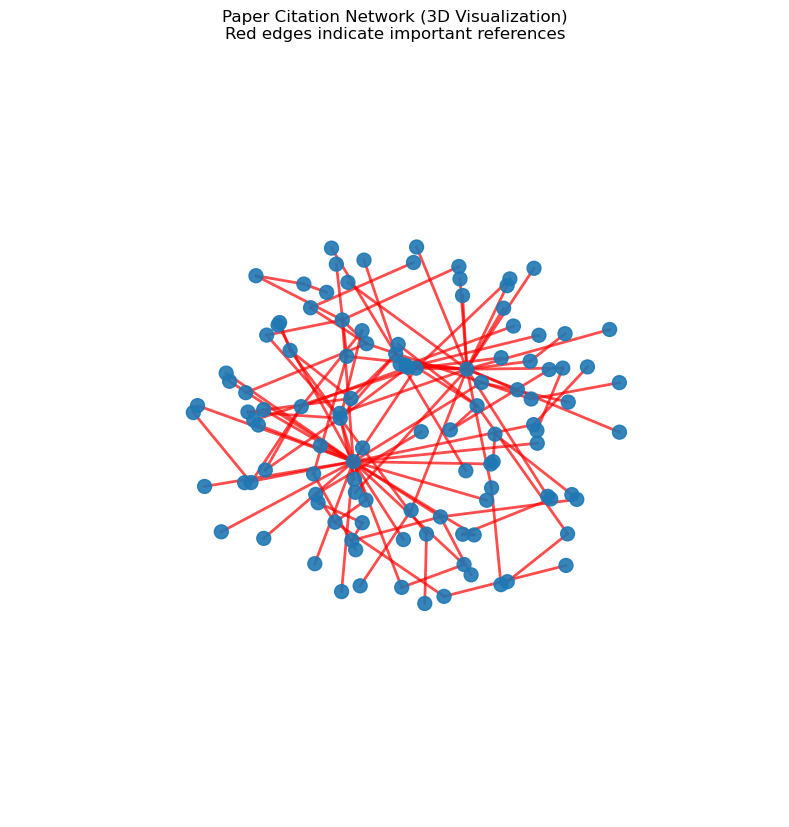

In [54]:

if not nx.is_connected(G_important):
    largest_cc = max(nx.connected_components(G_important), key=len)
    G_important = G_important.subgraph(largest_cc).copy()
    print(f"Using largest connected component with {G_important.number_of_nodes()} nodes.")
    
    # Compute 3D positions
pos_3d = nx.spring_layout(G_important, dim=3, k=5, iterations=500)
    
    # Prepare for 3D plotting
x_values = [pos[0] for pos in pos_3d.values()]
y_values = [pos[1] for pos in pos_3d.values()]
z_values = [pos[2] for pos in pos_3d.values()]
    
    # Start 3D plotting
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
    
    # Draw nodes
node_colors = '#1f78b4'  # You can customize node colors
ax.scatter(x_values, y_values, z_values, s=100, c=node_colors, alpha=0.9)
    
    # Draw edges
for i, (u, v) in enumerate(G_important.edges()):
    x = [pos_3d[u][0], pos_3d[v][0]]
    y = [pos_3d[u][1], pos_3d[v][1]]
    z = [pos_3d[u][2], pos_3d[v][2]]
    color = 'red' if G_important[u][v]['most_important_references'] == 1 else 'blue'
    ax.plot(x, y, z, color=color, alpha=0.7, linewidth=2)
    
    # Optionally, add labels
    # for node, (x, y, z) in pos_3d.items():
    #     ax.text(x, y, z, s=node, fontsize=8)
    
ax.set_title("Paper Citation Network (3D Visualization)\nRed edges indicate important references")
ax.axis('off')
plt.show()